## 0. Import modules and run an example of dummy_gym

2024-10-30 17:45:00.587778: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-30 17:45:02.079942: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humble/lib/x86_64-linux-gnu:/opt/ros/humble/lib
2024-10-30 17:45:02.080059: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot ope

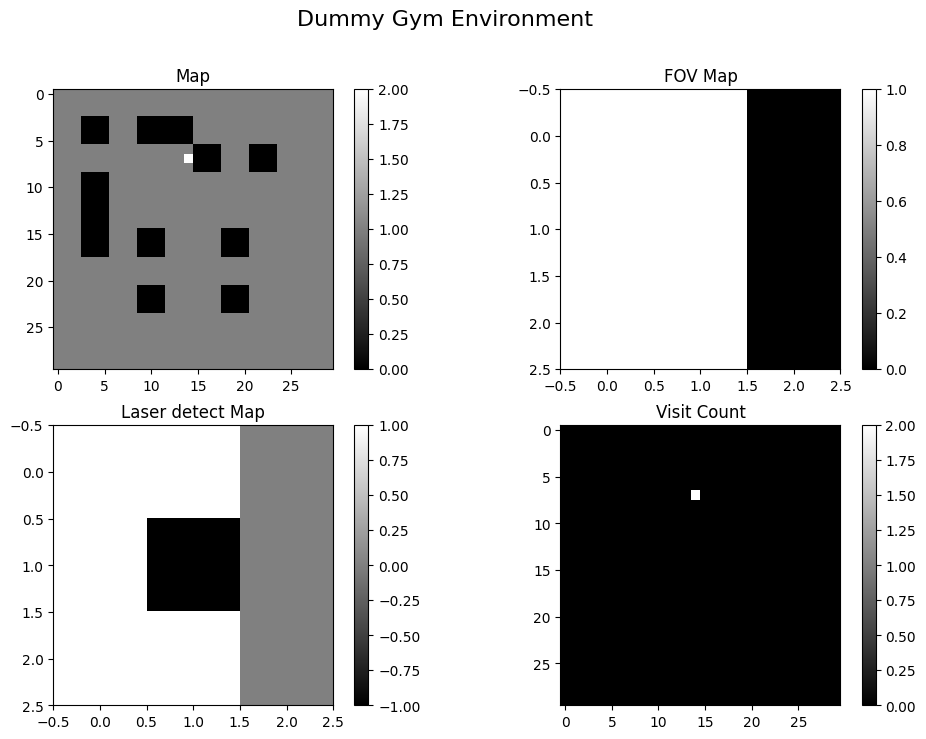

4


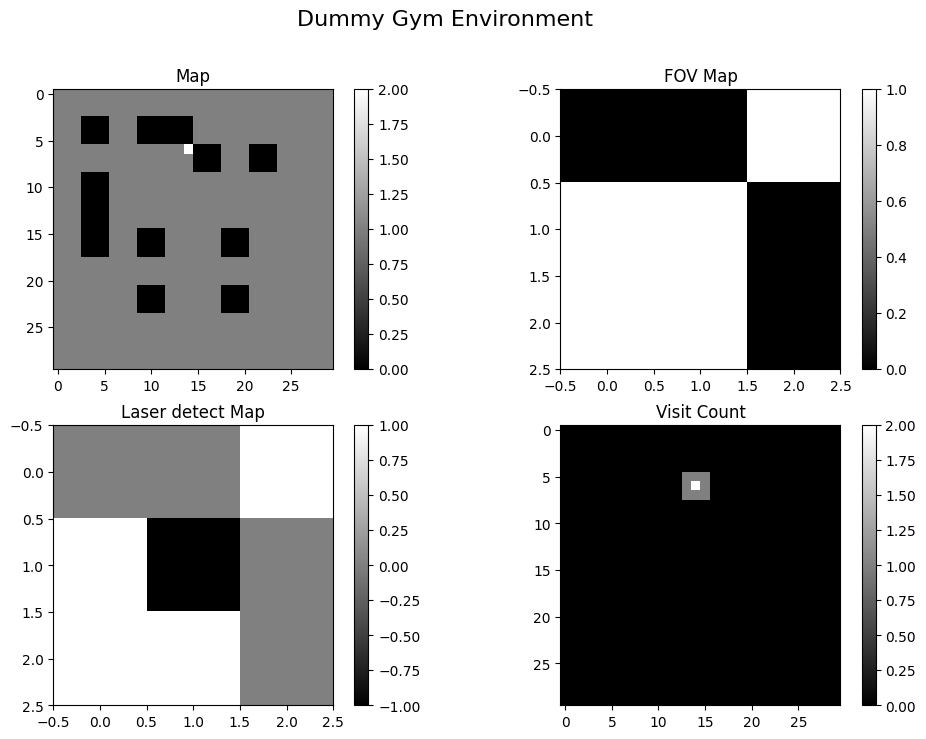

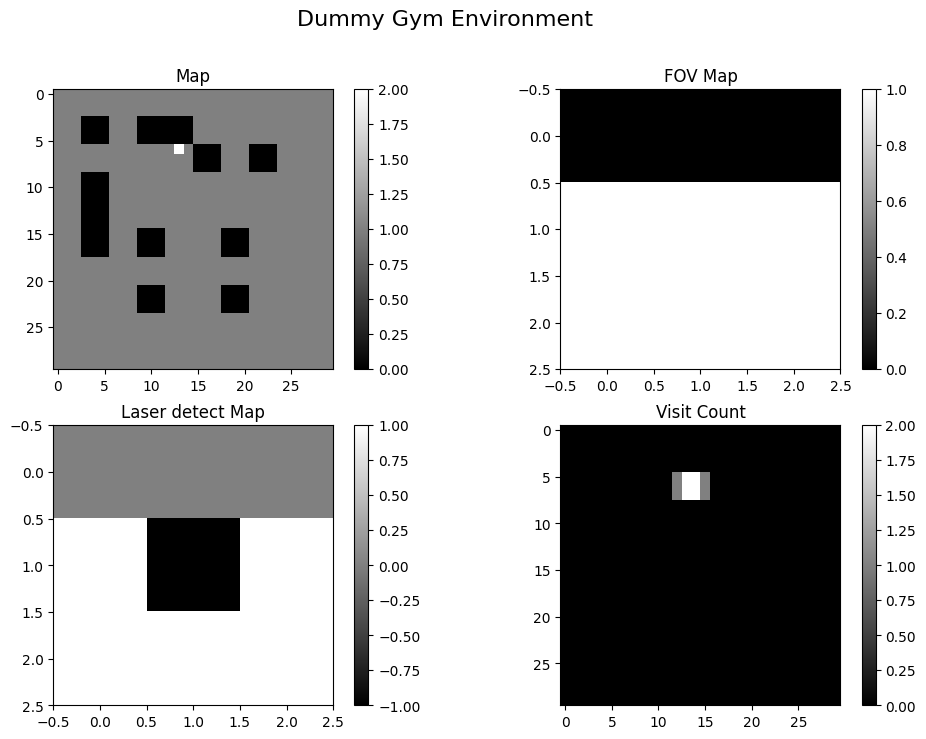

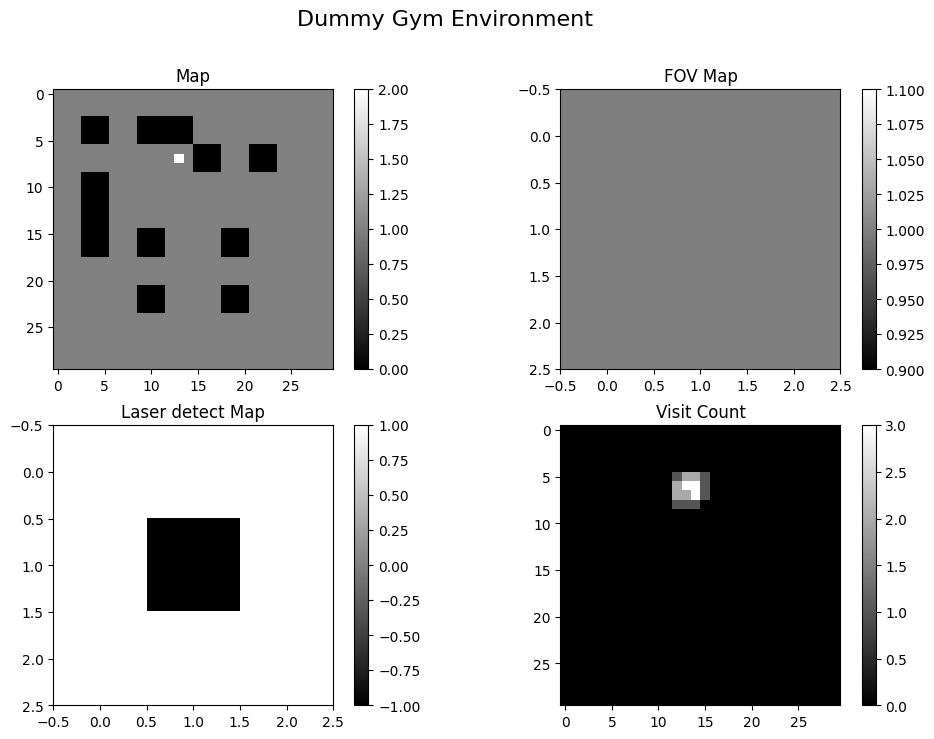

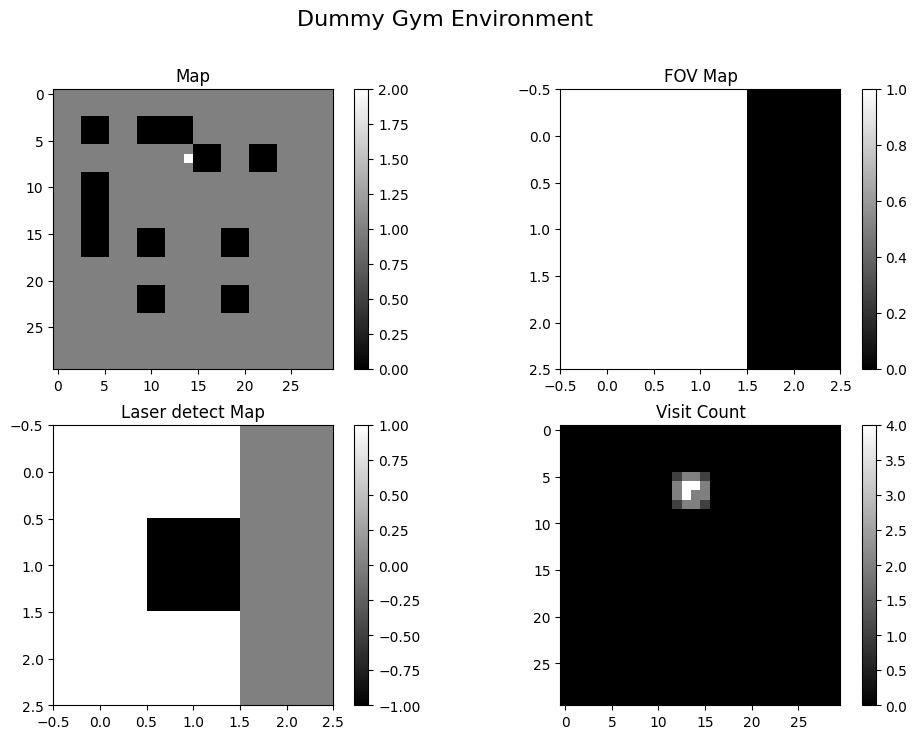

In [1]:
# Import the necessary libraries
import tensorflow as tf
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from dummy_gym import DummyGym

# Only I need to do this because I am running the code on my local machine
import os
os.chdir('/home/zhihan/ME5418')

# Create the environment instance
env = DummyGym()


## 1. Parameters setting
In order to test our model, we did not assign large parameters

In [2]:
# Hyperparameters
original_state = env.observe()
action_size = env.action_space.n
print(f'action_size is {action_size}')
batch_size = 8 # 每次训练的数据量
n_episodes = 1 # 地图数量
time_steps = 3000 # 小车移动次数
epochs = 4 # 每个地图训练次数

# DQN parameters
gamma = 0.99  # discount rate
epsilon = 1.0  # exploration rate
epsilon_min = 0.01 # 最小探索率
epsilon_decay = 0.995 # 探索衰减率

# Replay buffer
replay_buffer = deque(maxlen=2000) # 用于存储训练数据


action_size is 4


## 2. Processing states
The state we get from dummy_gym are lists and have only 2 dimensions. So we have to
1. Use `np.array` to change the type of state to `ndarray` for future data processing
2. Use `map.reshape((*map.shape, 1))` to reshape the state to 3 dimensions

In [3]:
# 处理原始state
def prepare_state(original_state):
    visit_count, fov_map, car_pos = original_state
    visit_count, fov_map, car_pos = np.array(visit_count), np.array(fov_map), np.array(car_pos)

    # add channel dimension
    visit_count_state = visit_count.reshape((*visit_count.shape, 1))
    fov_map_state = fov_map.reshape((*fov_map.shape, 1))
    car_pos_state = car_pos.reshape((*car_pos.shape, 1))
    
    return [visit_count_state, fov_map_state, car_pos_state], [visit_count_state.shape, fov_map_state.shape, car_pos_state.shape]
_, state_shape = prepare_state(original_state)
# print(state_shape[0], state_shape[1], state_shape[2])

## 3. Designing out model
After comparing different model output, we found that model behaves best when follows these settings:
1. `pool=True`
2. `dropout=True`
3. `residual=True`
4. `batch_norm=True`
5. `regularizer=None`

You can see the summay of the model in below ceil.\
ps: Different model's outputs are under `dqn_loss_output` file

In [4]:
def create_dqn_model(conv_filters_1=32, conv_filters_2=16, kernel_size=(3,3), activation='sigmoid', dense_units_1=64, dense_units_2=32, pool_size=(2,2), pool=True, dropout=True, residual=True, batch_norm=True, regularizer=None):
    # Input for state_array[0].shape array(120*120)
    input_visit_count_state = tf.keras.layers.Input(shape=state_shape[0], name='input_visit_count_state')
    conv_visit_count_state = tf.keras.layers.Conv2D(conv_filters_1, kernel_size, activation=activation, padding='same')(input_visit_count_state)
    conv_visit_count_state = tf.keras.layers.Conv2D(conv_filters_1, kernel_size, activation=activation, padding='same')(conv_visit_count_state)
    # print(conv_visit_count_state.shape)

    # different settings    
    batch_norm_visit_count_state = tf.keras.layers.BatchNormalization()(conv_visit_count_state) if batch_norm else conv_visit_count_state
    residual_visit_count_state = tf.keras.layers.Add()([input_visit_count_state, batch_norm_visit_count_state])     if residual else batch_norm_visit_count_state
    dropout_visit_count_state  = tf.keras.layers.Dropout(0.2)(residual_visit_count_state)                     if dropout  else residual_visit_count_state
    pool_visit_count_state     = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(dropout_visit_count_state) if pool     else dropout_visit_count_state
    
    flat_visit_count_state = tf.keras.layers.Flatten()(pool_visit_count_state)

    # Input for state_array[1].shape 10x10 array
    input_fov_map = tf.keras.layers.Input(shape=state_shape[1], name='input_fov_map')
    conv_fov_map = tf.keras.layers.Conv2D(conv_filters_2, kernel_size, activation=activation, padding='same')(input_fov_map)
    conv_fov_map = tf.keras.layers.Conv2D(conv_filters_2, kernel_size, activation=activation, padding='same')(conv_fov_map)
    # print(conv_fov_map.shape)

    # different settings
    batch_norm_fov_map = tf.keras.layers.BatchNormalization()(conv_fov_map) if batch_norm else conv_fov_map
    residual_fov_map = tf.keras.layers.Add()([input_fov_map, batch_norm_fov_map]) if residual else batch_norm_fov_map
    dropout_fov_map_state = tf.keras.layers.Dropout(0.2)(residual_fov_map) if dropout else residual_fov_map
    pool_fov_map_state = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(dropout_fov_map_state) if pool else dropout_fov_map_state
    
    flat_fov_map = tf.keras.layers.Flatten()(pool_fov_map_state)

    # Input for 2x1 array
    input_car_pos = tf.keras.layers.Input(shape=state_shape[2], name='input_car_pos')
    dense_car_pos = tf.keras.layers.Flatten()(input_car_pos)

    # Concatenate all branches
    combined = tf.keras.layers.Concatenate()([flat_visit_count_state, flat_fov_map, dense_car_pos])

    # Fully connected layers after concatenation
    dense1 = tf.keras.layers.Dense(dense_units_1, activation=activation, kernel_regularizer=regularizer)(combined)
    dense2 = tf.keras.layers.Dense(dense_units_2, activation=activation, kernel_regularizer=regularizer)(dense1)
    output = tf.keras.layers.Dense(action_size, activation='linear', kernel_regularizer=regularizer)(dense2)

    # Create the model
    model = tf.keras.Model(inputs=[input_visit_count_state, input_fov_map, input_car_pos], outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model

# Create the DQN model and target model
model = create_dqn_model()
target_model = create_dqn_model()
target_model.set_weights(model.get_weights())  # Initialize target model weights
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_visit_count_state (Input  [(None, 30, 30, 1)]  0          []                               
 Layer)                                                                                           
                                                                                                  
 input_fov_map (InputLayer)     [(None, 3, 3, 1)]    0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 32)   320         ['input_visit_count_state[0][0]']
                                                                                                  
 conv2d_2 (Conv2D)              (None, 3, 3, 16)     160         ['input_fov_map[0][0]']      

2024-10-30 16:25:42.844372: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-10-30 16:25:42.844398: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Legion): /proc/driver/nvidia/version does not exist
2024-10-30 16:25:42.844937: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 add_1 (Add)                    (None, 3, 3, 16)     0           ['input_fov_map[0][0]',          
                                                                  'batch_normalization_1[0][0]']  
                                                                                                  
 dropout (Dropout)              (None, 30, 30, 32)   0           ['add[0][0]']                    
                                                                                                  
 dropout_1 (Dropout)            (None, 3, 3, 16)     0           ['add_1[0][0]']                  
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 15, 15, 32)   0           ['dropout[0][0]']                
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 1, 1, 16)    0           ['dropout_1[0][0]']              
          

## 4. Select actions
Actions are selected randomly with the possibility of epsilon. Otherwise will be selected based on `q_values`.

In [4]:
def select_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)  # Explore: random action
    q_values = model.predict(state)
    return np.argmax(q_values[0])  # Exploit: select action with max Q-value


## 5. Define function of trainnign model
1. **Sample a Minibatch**:
   - A minibatch of experiences is randomly sampled from the `replay_buffer` to train the model. Each experience is in the format `(state, action, reward, next_state, done)`.

2. **Loop through each Experience**:
   - The code iterates through each experience in the minibatch to update the model. 

3. **Initialize Target**:
   - The immediate reward is set as the initial target.

4. **Adjust Batch Dimension**:
   - This step ensures that the state tensors have a batch dimension (shape of 4D) by expanding dimensions if needed.

5. **Compute Target if Episode Not Done**:
   - If the episode is not finished (`done` is `False`), the target Q-value is updated using the formula:\
     $
     \text{target} = \text{reward} + \gamma \cdot \max_{a'} Q_{\text{target\_model}}(\text{next\_state}, a')
     $
   - `gamma` is the discount factor that weighs the contribution of future rewards. The target model is used to predict the Q-values of the next state.

6. **Update Predicted Q-Values**:
   - The current state's Q-values are predicted, and the Q-value for the action taken is updated with the calculated target value.

7. **Train the Model**:
   - The model is trained on the current state and updated Q-values for `epochs` iterations. The loss for each training step is stored in `history`.

8. **Plot Loss**:
   - This section plots the loss curve for the training steps within this minibatch.

9. **Update Target Model Weights**:
   - After training, the weights of the target model are updated to match the main model. This helps stabilize training by having a slightly outdated model (target model) to compare predictions.

10. **Return the Losses**:
    - The function returns the loss values for further analysis.

In [5]:
def train_dqn(batch_size):
    minibatch = random.sample(replay_buffer, batch_size) # Sample minibatch from the replay buffer
    losses = []
    for state, action, reward, next_state, done in minibatch: # 从小批量样本中获取数据
        # print(state[0].shape)
        target = reward
        # print("target:", target)
        if not done:
            # add batch dimension
            if len(state[0].shape) != 4:
                state[0] = np.expand_dims(state[0], axis=0)
                # print("state[0].shape after expand_dims", state[0].shape)
                state[1] = np.expand_dims(state[1], axis=0)
                state[2] = np.expand_dims(state[2], axis=0)
            if len(next_state[0].shape) != 4:
                next_state[0] = np.expand_dims(next_state[0], axis=0)
                # print("next_state[0].shape after expand_dims", next_state[0].shape)
                next_state[1] = np.expand_dims(next_state[1], axis=0)
                next_state[2] = np.expand_dims(next_state[2], axis=0)
            target += gamma * np.amax(target_model.predict([next_state[0], next_state[1], next_state[2]])[0])
            # print("target after update:", target)
        
        target_q_values = model.predict([state[0], state[1], state[2]])
        print(f'Ready to take action:{action}')
        target_q_values[0][action] = target
        history = model.fit([state[0], state[1], state[2]], target_q_values, epochs=epochs, verbose=1) # 对这个小批量样本训练epochs次,verbose=1表示显示训练进度条
        loss = history.history['loss']
        # plt.plot(loss)
        # plt.xlabel('Epochs')
        # plt.ylabel('Loss')
        # plt.show()

    # Update target model weights
    target_model.set_weights(model.get_weights())
    return losses


## 6. Start tranning!
1. **Initialize Tracking Lists**:
   - These lists store total rewards for each episode and rewards for each time step for tracking and plotting purposes.

2. **Loop Over Episodes**:
   - Iterates through a set number of episodes (`n_episodes`), each representing a complete run of the environment.

3. **Environment Reset**:
   - Resets the environment at the start of each episode and prepares the initial state.

4. **Loop Over Time Steps**:
   - Within each episode, it loops through a maximum number of time steps (`time_steps`), representing agent actions within the environment.

5. **Select and Execute an Action**:
   - Selects an action based on the current policy (using an epsilon-greedy strategy) and takes a step in the environment to obtain the next state, reward, and done flag.

6. **Render and Prepare Next State**:
   - Renders the environment (to visualize changes) and processes the next state for input into the network.

7. **Store Experience**:
   - The current experience `(state, action, reward, next_state, done)` is added to the replay buffer to be used later for training.

8. **Update Rewards**:
   - Adds the reward received at the current time step to the total reward for the episode.

9. **Check if Episode is Complete**:
   - Ends the episode if the `done` flag is set to `True` and prints the episode's result.

10. **Train the Model if Replay Buffer is Large Enough**:
    - If the replay buffer contains enough samples, the DQN model is trained using a batch of experiences.

11. **Store Total Reward and Update Epsilon**:
    - Appends the total reward for the episode to `rewards_list` and decays epsilon to gradually reduce exploration.


********************Episode: 1/1********************
-------------------Time step: 0------------------------


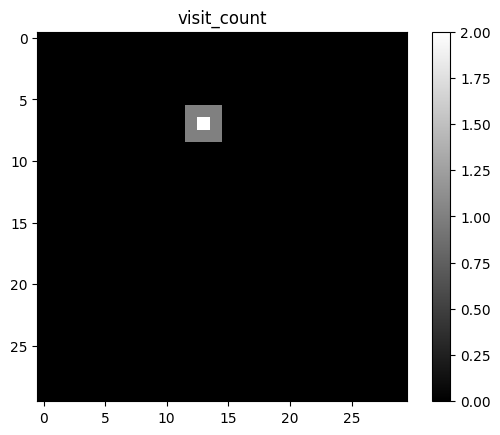

-------------------Time step: 1------------------------
-------------------Time step: 2------------------------
-------------------Time step: 3------------------------
-------------------Time step: 4------------------------
-------------------Time step: 5------------------------
-------------------Time step: 6------------------------
-------------------Time step: 7------------------------
-------------------Time step: 8------------------------
Start training DQN model with batch size: 8
1/1 [==============================] - 0s 70ms/step
Ready to take action:3
Epoch 1/4
1/1 [==============================] - 1s 902ms/step - loss: 0.7221
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.1771
Epoch 3/4
1/1 [==============================] - 0s 7ms/step - loss: 0.1076
Epoch 4/4
1/1 [==============================] - 0s 15ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0871
Epoch 2/4
1/1 [===========================

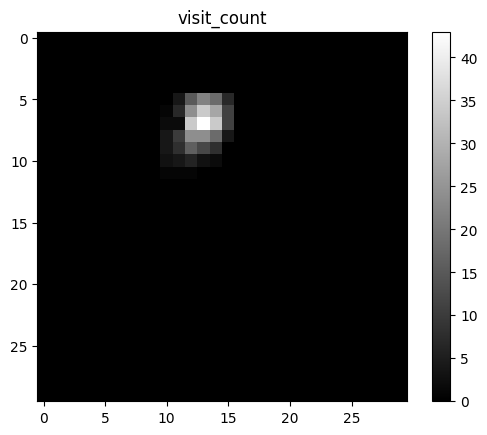

Start training DQN model with batch size: 8
1/1 [==============================] - 0s 14ms/step
Ready to take action:1
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 1.1189e-04
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 6.2095e-04
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 4/4
1/1 [==============================] - 0s 14ms/step
Ready to take action:0
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0055
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0065
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0073
Epoch 4/4
1/1 [==============================] - 0s 15ms/step
Ready to take action:0
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0080
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0079
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0077
Epoch 4/4
1/1 [====

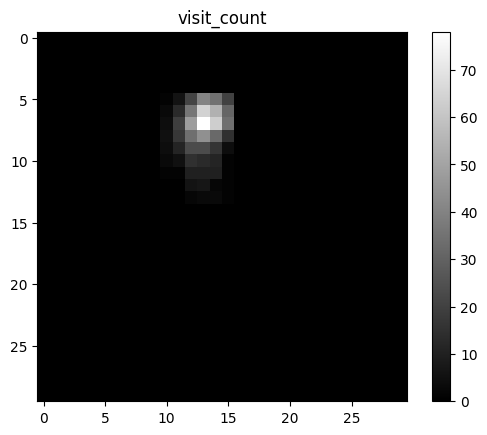

Start training DQN model with batch size: 8
1/1 [==============================] - 0s 16ms/step
Ready to take action:1
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0035
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0034
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 4/4
1/1 [==============================] - 0s 14ms/step
Ready to take action:0
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 1.4309e-04
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 3.1422e-04
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 7.1683e-04
Epoch 4/4
1/1 [==============================] - 0s 14ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 4/4
1/1 [

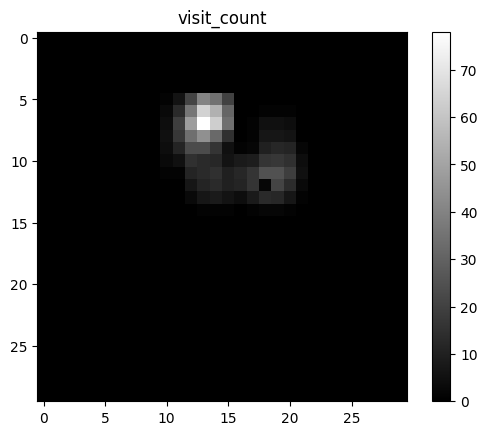

Start training DQN model with batch size: 8
1/1 [==============================] - 0s 19ms/step
Ready to take action:3
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 7.6317e-04
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 7.9040e-04
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 8.2531e-04
Epoch 4/4
1/1 [==============================] - 0s 18ms/step
Ready to take action:1
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 4/4
1/1 [==============================] - 0s 20ms/step
Ready to take action:0
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0058
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0056
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 4/4
1/1 [

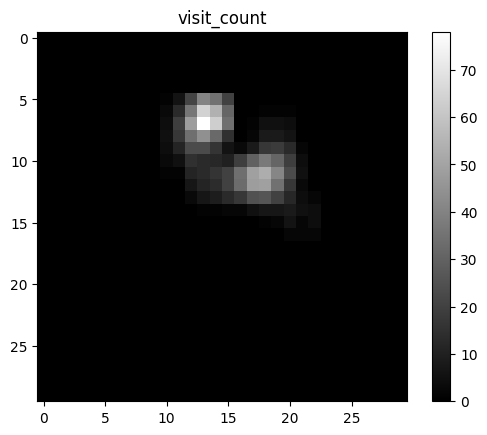

Start training DQN model with batch size: 8
1/1 [==============================] - 0s 15ms/step
Ready to take action:1
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 9.9265e-04
Epoch 4/4
1/1 [==============================] - 0s 16ms/step
Ready to take action:3
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 3/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 4/4
1/1 [==============================] - 0s 14ms/step
Ready to take action:0
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 9.0933e-06
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 3.4947e-05
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 9.7474e-05
Epoch 4/4
1

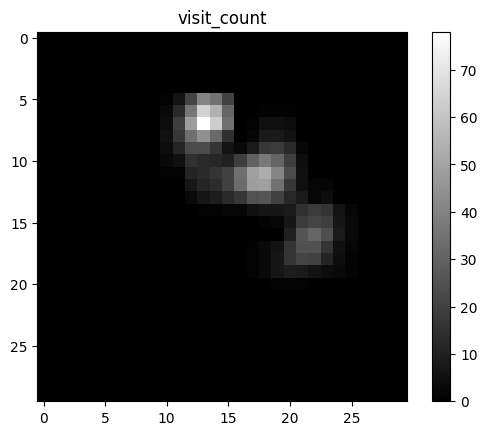

Start training DQN model with batch size: 8
1/1 [==============================] - 0s 17ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 30ms/step - loss: 1.4994e-06
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 3.6854e-05
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 1.2738e-04
Epoch 4/4
1/1 [==============================] - 0s 15ms/step
Ready to take action:1
Epoch 1/4
1/1 [==============================] - 0s 8ms/step - loss: 4.5918e-04
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 3.7103e-04
Epoch 3/4
1/1 [==============================] - 0s 7ms/step - loss: 2.5157e-04
Epoch 4/4
1/1 [==============================] - 0s 15ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 9.4763e-04
Epoch 2/4
1/1 [==============================] - 0s 5ms/step - loss: 7.3786e-04
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 4

In [ ]:
# Track rewards for plotting
rewards_list = []
time_step_rewards = []

for episode in range(n_episodes): # 训练多少张图
    print(f"\n********************Episode: {episode+1}/{n_episodes}********************")
    state = env.reset()
    # print(np.array(state[0]).shape)
    state,_ = prepare_state(state)
    # state = np.reshape(state, [1, *state.shape])
    total_reward = 0
    time_step_rewards.append(total_reward)
    
    for time_step in range(time_steps):  # 每张图训练小车走至多多少步
        print(f"-------------------Time step: {time_step}------------------------")
        action = select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        if time_step % 50 == 0:
            env.render(map_type="visit_count")
        next_state,_ = prepare_state(next_state)
        # next_state = np.reshape(next_state, [1, *state_size])
        
        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        time_step_rewards.append(total_reward)

        if done:
            print(f"Episode: {episode+1}/{n_episodes}, Reward: {total_reward}, Epsilon: {epsilon:.2f}")
            env.render(map_type="visit_count")
            break

        if len(replay_buffer) > batch_size: # 当步数大于batch size时开始训练
            print(f"Start training DQN model with batch size: {batch_size}")
            losses = train_dqn(batch_size)
            # save model
            model.save('dqn_model.h5')
    
    rewards_list.append(total_reward)
    
    # Decay epsilon after each episode
    # if epsilon > epsilon_min:
    #     epsilon *= epsilon_decay

2024-10-30 17:46:00.426765: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-10-30 17:46:00.426790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Legion): /proc/driver/nvidia/version does not exist
2024-10-30 17:46:00.427338: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



********************Episode: 1/1********************
-------------------Time step: 0------------------------


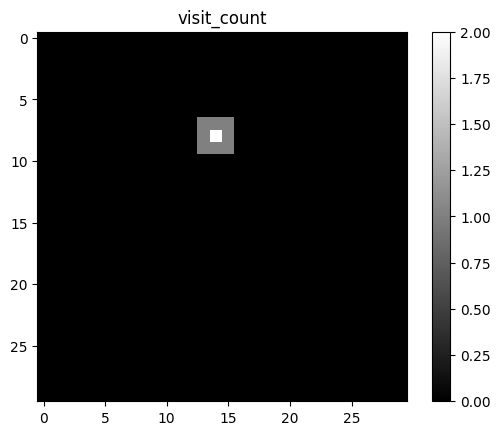

-------------------Time step: 1------------------------
-------------------Time step: 2------------------------
-------------------Time step: 3------------------------
-------------------Time step: 4------------------------
-------------------Time step: 5------------------------
-------------------Time step: 6------------------------
-------------------Time step: 7------------------------
-------------------Time step: 8------------------------
Start training DQN model with batch size: 8
1/1 [==============================] - 0s 67ms/step
Ready to take action:0
Epoch 1/4
1/1 [==============================] - 1s 542ms/step - loss: 0.1629
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.1572
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.1469
Epoch 4/4
1/1 [==============================] - 0s 15ms/step
Ready to take action:3
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0355
Epoch 2/4
1/1 [===========================

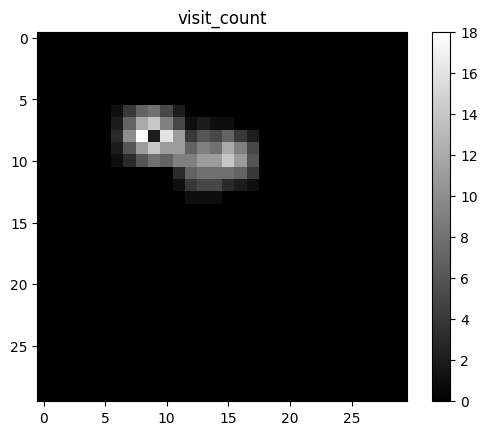

Start training DQN model with batch size: 8
1/1 [==============================] - 0s 15ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 3.0416e-04
Epoch 2/4
1/1 [==============================] - 0s 5ms/step - loss: 2.6179e-04
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 1.7606e-04
Epoch 4/4
1/1 [==============================] - 0s 14ms/step
Ready to take action:0
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 8.8960e-07
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 1.9538e-05
Epoch 3/4
1/1 [==============================] - 0s 5ms/step - loss: 6.0513e-05
Epoch 4/4
1/1 [==============================] - 0s 14ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 2.7107e-04
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 2.3604e-04
Epoch 3/4
1/1 [==============================] - 0s 5ms/step - loss: 1.

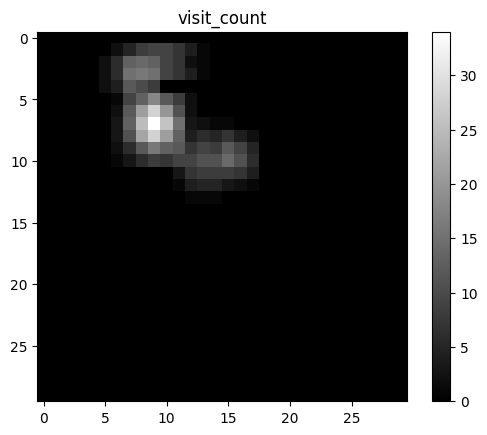

Start training DQN model with batch size: 8
1/1 [==============================] - 0s 15ms/step
Ready to take action:3
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0244
Epoch 2/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0254
Epoch 3/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0260
Epoch 4/4
1/1 [==============================] - 0s 15ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 2.7817e-04
Epoch 2/4
1/1 [==============================] - 0s 5ms/step - loss: 3.7162e-04
Epoch 3/4
1/1 [==============================] - 0s 8ms/step - loss: 6.3957e-04
Epoch 4/4
1/1 [==============================] - 0s 14ms/step
Ready to take action:1
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0231
Epoch 2/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0203
Epoch 3/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0170
Epoch 4/4
1/1 [

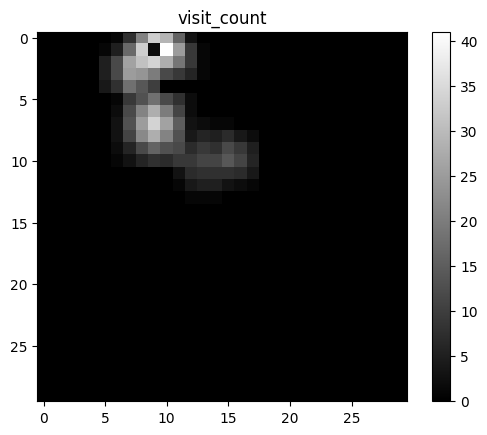

Start training DQN model with batch size: 8
1/1 [==============================] - 0s 16ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 3.8037e-04
Epoch 2/4
1/1 [==============================] - 0s 5ms/step - loss: 4.0932e-04
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 4.7373e-04
Epoch 4/4
1/1 [==============================] - 0s 15ms/step
Ready to take action:0
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0231
Epoch 2/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0214
Epoch 3/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0196
Epoch 4/4
1/1 [==============================] - 0s 14ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 4.7943e-04
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 5.3410e-04
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 6.3372e-04
Epo

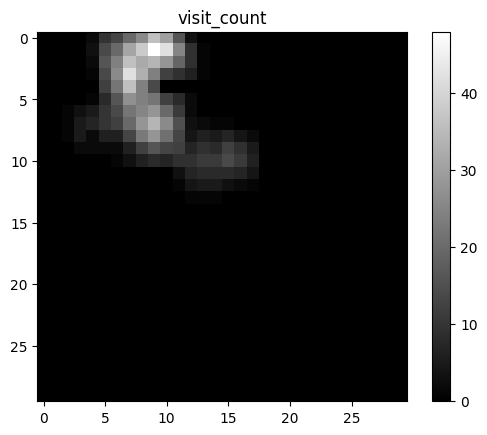

Start training DQN model with batch size: 8
1/1 [==============================] - 0s 14ms/step
Ready to take action:3
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0021
Epoch 2/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0019
Epoch 3/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 4/4
1/1 [==============================] - 0s 14ms/step
Ready to take action:1
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 7.8442e-05
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 8.0322e-05
Epoch 3/4
1/1 [==============================] - 0s 5ms/step - loss: 9.2043e-05
Epoch 4/4
1/1 [==============================] - 0s 13ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 1.2910e-04
Epoch 2/4
1/1 [==============================] - 0s 5ms/step - loss: 1.2767e-04
Epoch 3/4
1/1 [==============================] - 0s 5ms/step - loss: 1.2593e-04
Epo

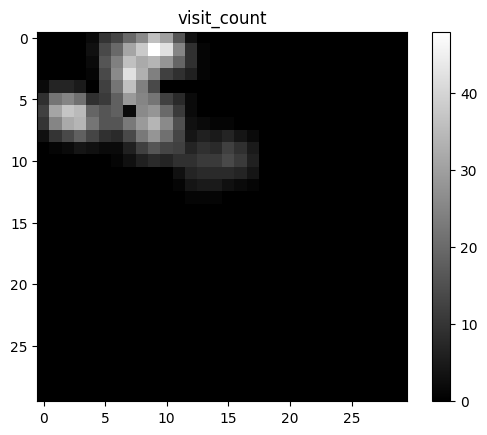

Start training DQN model with batch size: 8
1/1 [==============================] - 0s 15ms/step
Ready to take action:0
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0058
Epoch 2/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 3/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 4/4
1/1 [==============================] - 0s 14ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 0.1043
Epoch 2/4
1/1 [==============================] - 0s 5ms/step - loss: 0.1027
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0983
Epoch 4/4
1/1 [==============================] - 0s 14ms/step
Ready to take action:3
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 1.2800e-05
Epoch 2/4
1/1 [==============================] - 0s 5ms/step - loss: 1.7340e-04
Epoch 3/4
1/1 [==============================] - 0s 5ms/step - loss: 5.8510e-04
Epoch 4/4
1/1 [

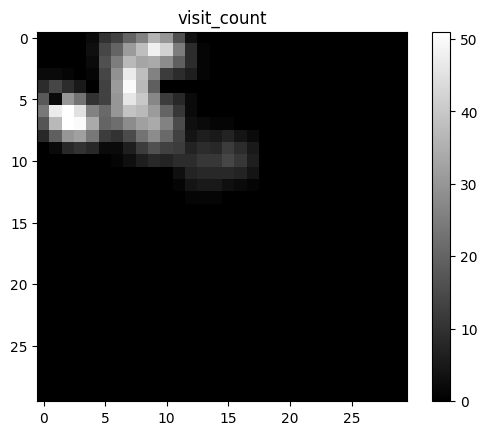

Start training DQN model with batch size: 8
1/1 [==============================] - 0s 21ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 4.7358e-05
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 2.0587e-04
Epoch 3/4
1/1 [==============================] - 0s 5ms/step - loss: 6.1172e-04
Epoch 4/4
1/1 [==============================] - 0s 17ms/step
Ready to take action:0
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0222
Epoch 2/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0212
Epoch 3/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0198
Epoch 4/4
1/1 [==============================] - 0s 17ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 2.2955e-04
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 2.9054e-04
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 4.4245e-04
Epo

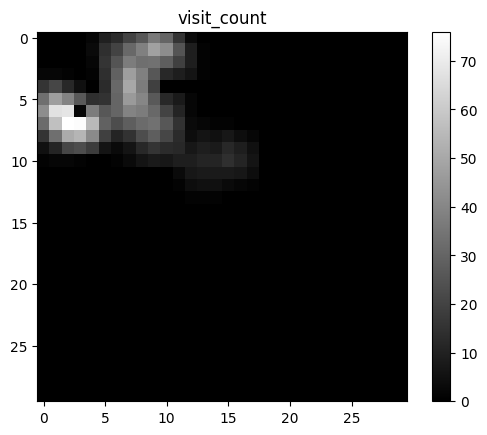

Start training DQN model with batch size: 8
1/1 [==============================] - 0s 15ms/step
Ready to take action:3
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 2/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 4/4
1/1 [==============================] - 0s 14ms/step
Ready to take action:0
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 0.1607
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.1594
Epoch 3/4
1/1 [==============================] - 0s 5ms/step - loss: 0.1547
Epoch 4/4
1/1 [==============================] - 0s 15ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0174
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0164
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0154
Epoch 4/4
1/1 [============

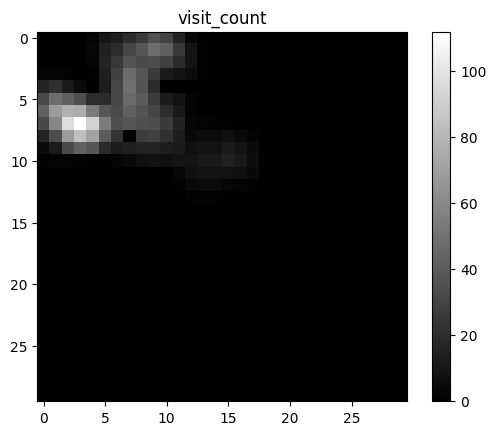

Start training DQN model with batch size: 8
1/1 [==============================] - 0s 18ms/step
Ready to take action:1
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 0.1619
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.1607
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.1556
Epoch 4/4
1/1 [==============================] - 0s 14ms/step
Ready to take action:3
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 6.3244e-04
Epoch 2/4
1/1 [==============================] - 0s 5ms/step - loss: 9.5717e-04
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 4/4
1/1 [==============================] - 0s 13ms/step
Ready to take action:3
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 2/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 3/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 4/4
1/1 [====

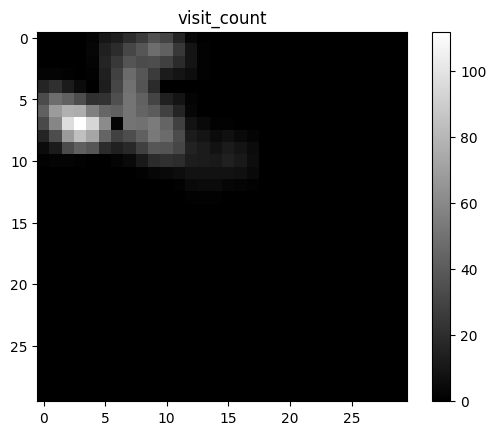

Start training DQN model with batch size: 8
1/1 [==============================] - 0s 14ms/step
Ready to take action:0
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 0.1047
Epoch 2/4
1/1 [==============================] - 0s 5ms/step - loss: 0.1013
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0959
Epoch 4/4
1/1 [==============================] - 0s 14ms/step
Ready to take action:0
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0229
Epoch 2/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0264
Epoch 3/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0290
Epoch 4/4
1/1 [==============================] - 0s 14ms/step
Ready to take action:1
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.1613
Epoch 2/4
1/1 [==============================] - 0s 5ms/step - loss: 0.1581
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.1514
Epoch 4/4
1/1 [============

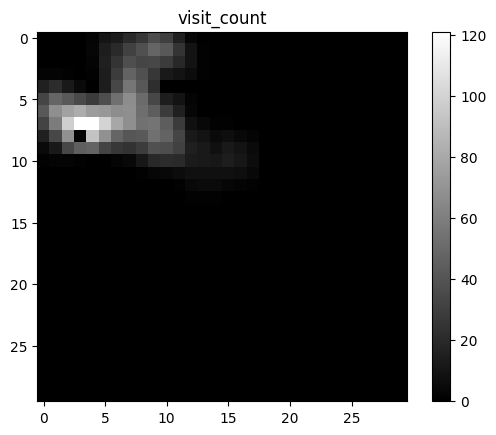

Start training DQN model with batch size: 8
1/1 [==============================] - 0s 18ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 2/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 3/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 4/4
1/1 [==============================] - 0s 16ms/step
Ready to take action:0
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0330
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0315
Epoch 3/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0295
Epoch 4/4
1/1 [==============================] - 0s 16ms/step
Ready to take action:1
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 2.5490e-05
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 8.2592e-05
Epoch 3/4
1/1 [==============================] - 0s 5ms/step - loss: 2.3256e-04
Epoch 4/4
1/1 [

KeyboardInterrupt: 

In [6]:
# Track rewards for plotting
rewards_list = []
time_step_rewards = []
model = tf.keras.models.load_model('dqn_model.h5')
target_model = tf.keras.models.load_model('dqn_model.h5')
replay_buffer = np.load('replay_buffer.npy', allow_pickle=True)

for episode in range(n_episodes): # 训练多少张图
    print(f"\n********************Episode: {episode+1}/{n_episodes}********************")
    state = env.reset()
    # print(np.array(state[0]).shape)
    state,_ = prepare_state(state)
    # state = np.reshape(state, [1, *state.shape])
    total_reward = 0
    time_step_rewards.append(total_reward)
    
    for time_step in range(time_steps):  # 每张图训练小车走至多多少步
        print(f"-------------------Time step: {time_step}------------------------")
        action = select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        if time_step % 50 == 0:
            env.render(map_type="visit_count")
        next_state,_ = prepare_state(next_state)
        # next_state = np.reshape(next_state, [1, *state_size])
        
        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        time_step_rewards.append(total_reward)

        if done:
            print(f"Episode: {episode+1}/{n_episodes}, Reward: {total_reward}, Epsilon: {epsilon:.2f}")
            env.render(map_type="visit_count")
            break

        if len(replay_buffer) > batch_size: # 当步数大于batch size时开始训练
            print(f"Start training DQN model with batch size: {batch_size}")
            losses = train_dqn(batch_size)
            # save model
            model.save('dqn_model.h5')
            np.save('replay_buffer.npy', replay_buffer)
    
    rewards_list.append(total_reward)
    
    # Decay epsilon after each episode
    # if epsilon > epsilon_min:
    #     epsilon *= epsilon_decay